In [3]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [5]:
# define common modules 
import pandas as pd    
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore")

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print 'plot'
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    df = pd.read_csv(filename,header=0, sep=',',names=['date', 'open', 'high', 'low', 'close','volume'])
    #get close price
    data=df.as_matrix(columns=['close'])
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data


def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of n steps before shifting prediction run forward by n steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [6]:

# begining of LSTM model 

#import modules
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time #helper libraries
#import lstm

In [7]:
#Step 1 Load Data
X_train, y_train, X_test, y_test = load_data('goog.csv', 30, True)

In [8]:
#Step 2 Build Model
model = Sequential()

#use default stateful=False because it is windowed and normalised and shuffled  
model.add(LSTM(
    input_dim=1,
    output_dim=30,
    return_sequences=True))
model.add(Dropout(0.2))

# model.add(LSTM(
#     100,
#     return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(
#     200,
#     return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(
#     100,
#     return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(
    50,
    return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
    30,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    10,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='adam')
print 'compilation time : ', time.time() - start

compilation time :  0.0148980617523


In [9]:
#Create call back for tensorboard
# tensorboard --logdir=/full_path_to_your_logs
now = time.strftime("%c")
cb1 = keras.callbacks.TensorBoard(log_dir='./keras_callback_logs/'+now, histogram_freq=0, write_graph=True, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#Create call back for checkpoint
cb2 = keras.callbacks.ModelCheckpoint(filepath='weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=10)
#Early stopping callbacks
#cb3 = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')


#Step 3 Train the model
model.fit(
    X_train,
    y_train,
    batch_size=512,
    callbacks=[cb1,cb2],
    nb_epoch=100,
    validation_split=0.05)

Train on 2758 samples, validate on 146 samples
Epoch 1/100
2758/2758 [==============================] - 1s - loss: 0.0098 - val_loss: 0.0086
Epoch 2/100
2758/2758 [==============================] - 1s - loss: 0.0076 - val_loss: 0.0050
Epoch 3/100
2758/2758 [==============================] - 1s - loss: 0.0047 - val_loss: 0.0026
Epoch 4/100
2758/2758 [==============================] - 1s - loss: 0.0044 - val_loss: 0.0024
Epoch 5/100
2758/2758 [==============================] - 1s - loss: 0.0038 - val_loss: 0.0029
Epoch 6/100
2758/2758 [==============================] - 1s - loss: 0.0037 - val_loss: 0.0021
Epoch 7/100
2758/2758 [==============================] - 1s - loss: 0.0033 - val_loss: 0.0019
Epoch 8/100
2758/2758 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0021
Epoch 9/100
2758/2758 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0019
Epoch 10/100
2758/2758 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0019
Epoch 11/100

2758/2758 [==============================] - 1s - loss: 0.0011 - val_loss: 7.3260e-04
Epoch 85/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 7.4539e-04
Epoch 86/100
2758/2758 [==============================] - 1s - loss: 9.9730e-04 - val_loss: 7.1334e-04
Epoch 87/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 7.1550e-04
Epoch 88/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 7.1309e-04
Epoch 89/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 7.7350e-04
Epoch 90/100
2758/2758 [==============================] - 1s - loss: 9.7105e-04 - val_loss: 7.7130e-04
Epoch 91/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 7.1453e-04
Epoch 92/100
2758/2758 [==============================] - 1s - loss: 0.0011 - val_loss: 7.5191e-04
Epoch 93/100
2758/2758 [==============================] - 1s - loss: 0.0010 - val_loss: 6.9480e-04
Epoch 94/100
27

In [10]:
model.save('my_model2.h5')


plot


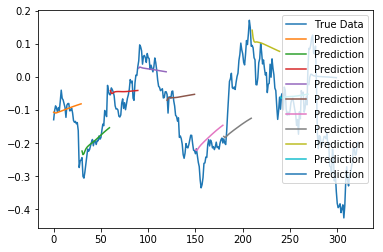

In [11]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, X_test, 30, 30)
plot_results_multiple(predictions, y_test, 30)

In [12]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 30)          3840      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 50)          16200     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 30)          9720      
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 30)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10)                1640      
__________